In [1]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import LocalOutlierFactor

from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("~/Desktop/Codes/house_prediction/Bengaluru_House_Data.csv")

In [3]:
df

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00
...,...,...,...,...,...,...,...,...,...
13315,Built-up Area,Ready To Move,Whitefield,5 Bedroom,ArsiaEx,3453,4.0,0.0,231.00
13316,Super built-up Area,Ready To Move,Richards Town,4 BHK,NaN,3600,5.0,NaN,400.00
13317,Built-up Area,Ready To Move,Raja Rajeshwari Nagar,2 BHK,Mahla T,1141,2.0,1.0,60.00
13318,Super built-up Area,18-Jun,Padmanabhanagar,4 BHK,SollyCl,4689,4.0,1.0,488.00


In [4]:
df1 = df.copy()

#Dropping unnecessary columns that are not relevant to the analysis
df1 = df1.drop(['availability', 'society', 'balcony'], axis='columns')
df1

,area_type,location,size,total_sqft,bath,price
0,Super built-up Area,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Plot Area,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Built-up Area,Uttarahalli,3 BHK,1440,2.0,62.00
3,Super built-up Area,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Super built-up Area,Kothanur,2 BHK,1200,2.0,51.00
...,...,...,...,...,...,...
13315,Built-up Area,Whitefield,5 Bedroom,3453,4.0,231.00
13316,Super built-up Area,Richards Town,4 BHK,3600,5.0,400.00
13317,Built-up Area,Raja Rajeshwari Nagar,2 BHK,1141,2.0,60.00
13318,Super built-up Area,Padmanabhanagar,4 BHK,4689,4.0,488.00


In [5]:
df1.columns

Index(['area_type', 'location', 'size', 'total_sqft', 'bath', 'price'], dtype='object')

In [6]:
# Create a new column 'size_bkh' by extracting the integer part from the 'size' column
df1['size_bkh'] = df1['size'].apply(lambda x: int(x.split(" ")[0]) if x is not None and isinstance(x, str) else x)

# Drop the 'size' column
df1.drop('size', axis=1, inplace=True)

# Display the DataFrame
df1

,area_type,location,total_sqft,bath,price,size_bkh
0,Super built-up Area,Electronic City Phase II,1056,2.0,39.07,2.0
1,Plot Area,Chikka Tirupathi,2600,5.0,120.00,4.0
2,Built-up Area,Uttarahalli,1440,2.0,62.00,3.0
3,Super built-up Area,Lingadheeranahalli,1521,3.0,95.00,3.0
4,Super built-up Area,Kothanur,1200,2.0,51.00,2.0
...,...,...,...,...,...,...
13315,Built-up Area,Whitefield,3453,4.0,231.00,5.0
13316,Super built-up Area,Richards Town,3600,5.0,400.00,4.0
13317,Built-up Area,Raja Rajeshwari Nagar,1141,2.0,60.00,2.0
13318,Super built-up Area,Padmanabhanagar,4689,4.0,488.00,4.0


In [7]:
# Getting the average value of the ranges in the 'total_sqft' column
def convert_range_to_avg(x):
    if x is None:
        return None
    try:
        # If x is a string, process it
        if isinstance(x, str):
            tokens = x.split('-')
            if len(tokens) == 2:
                return (float(tokens[0]) + float(tokens[1])) / 2
            return float(x)
        return x
    except ValueError:
        return None

# Apply the function to the 'total_sqft' column
df1['mod_total_sqft'] = df1['total_sqft'].apply(convert_range_to_avg)

# Drop the 'total_sqft' column
df1.drop('total_sqft', axis=1, inplace=True)

# Display the DataFrame
df1

,area_type,location,bath,price,size_bkh,mod_total_sqft
0,Super built-up Area,Electronic City Phase II,2.0,39.07,2.0,1056.0
1,Plot Area,Chikka Tirupathi,5.0,120.00,4.0,2600.0
2,Built-up Area,Uttarahalli,2.0,62.00,3.0,1440.0
3,Super built-up Area,Lingadheeranahalli,3.0,95.00,3.0,1521.0
4,Super built-up Area,Kothanur,2.0,51.00,2.0,1200.0
...,...,...,...,...,...,...
13315,Built-up Area,Whitefield,4.0,231.00,5.0,3453.0
13316,Super built-up Area,Richards Town,5.0,400.00,4.0,3600.0
13317,Built-up Area,Raja Rajeshwari Nagar,2.0,60.00,2.0,1141.0
13318,Super built-up Area,Padmanabhanagar,4.0,488.00,4.0,4689.0


In [8]:
df2 = df1.copy()

In [9]:
print(df2.isna().sum())

area_type          0
location           1
bath              73
price              0
size_bkh          16
mod_total_sqft    46
dtype: int64


In [10]:
df2 = df2.dropna()

In [11]:
#One hot encoding to check if the "area_type" column has any effect on the price of the house

#Specifying the categorical column
categorical_column = ['area_type']

#Creating the OneHotEncoder object
onehot_encoder = OneHotEncoder(sparse_output = False)

#Fitting the encoder to the data and transforming the data
encoded_data = onehot_encoder.fit_transform(df2[categorical_column])

#Creating a DataFrame from the encoded data
encoded_df = pd.DataFrame(encoded_data, columns = onehot_encoder.get_feature_names_out(categorical_column))

#Concatenating the original DataFrame with the encoded DataFrame
final_encoded_df = pd.concat([df2, encoded_df], axis = 1).drop(categorical_column, axis = 1)

#Printing the final DataFrame
final_encoded_df.head()

,location,bath,price,size_bkh,mod_total_sqft,area_type_Built-up Area,area_type_Carpet Area,area_type_Plot Area,area_type_Super built-up Area
0,Electronic City Phase II,2.0,39.07,2.0,1056.0,0.0,0.0,0.0,1.0
1,Chikka Tirupathi,5.0,120.00,4.0,2600.0,0.0,0.0,1.0,0.0
2,Uttarahalli,2.0,62.00,3.0,1440.0,1.0,0.0,0.0,0.0
3,Lingadheeranahalli,3.0,95.00,3.0,1521.0,0.0,0.0,0.0,1.0
4,Kothanur,2.0,51.00,2.0,1200.0,0.0,0.0,0.0,1.0


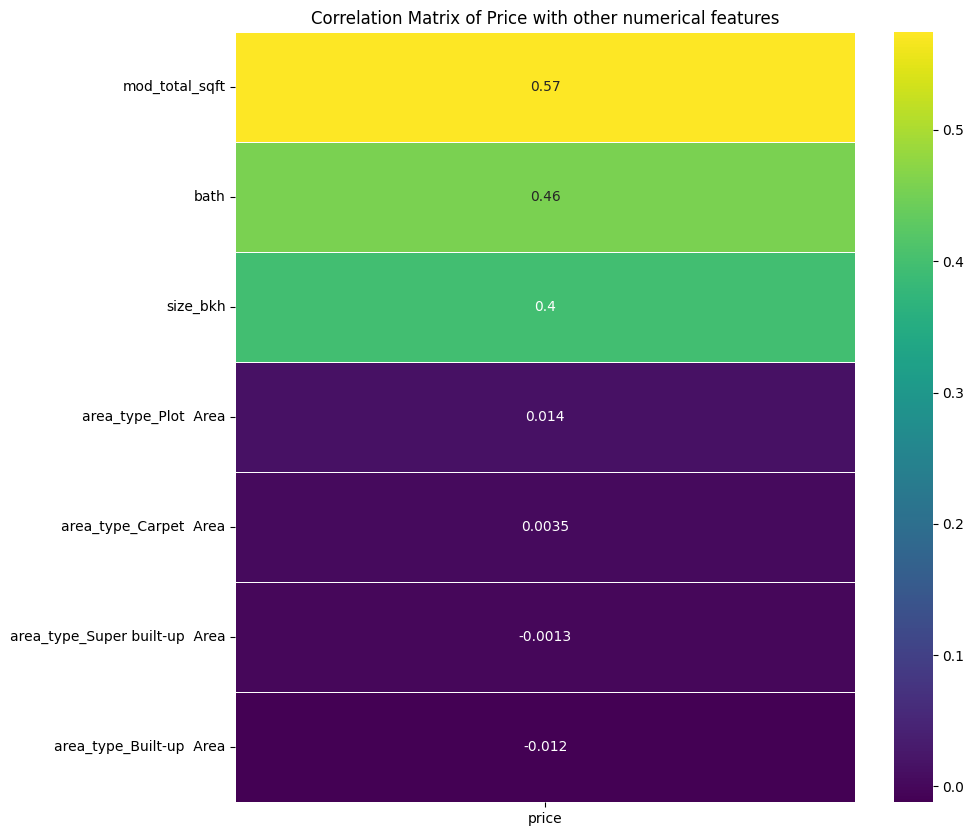

In [12]:
#Computing the correlation matrix
correlation_matrix = final_encoded_df.corr(numeric_only=True)

# Sort features by correlation with 'price' (descending order)
sorted_corr = correlation_matrix['price'].sort_values(ascending=False)

# Remove 'price' from the sorted_corr index
sorted_corr = sorted_corr.drop('price')

#Plotting the heat map
plt.figure(figsize=(10,10))
sns.heatmap(correlation_matrix.loc[sorted_corr.index, ['price']], annot=True, cmap='viridis', linewidths=0.5)

plt.title('Correlation Matrix of Price with other numerical features')
plt.show()

In [13]:
#Dropping unnecessary columns that are not relevant to the analysis
df3 = final_encoded_df.drop(['area_type_Built-up  Area', 'area_type_Carpet  Area', 'area_type_Plot  Area', 'area_type_Super built-up  Area'], axis='columns')
df3

,location,bath,price,size_bkh,mod_total_sqft
0,Electronic City Phase II,2.0,39.07,2.0,1056.0
1,Chikka Tirupathi,5.0,120.00,4.0,2600.0
2,Uttarahalli,2.0,62.00,3.0,1440.0
3,Lingadheeranahalli,3.0,95.00,3.0,1521.0
4,Kothanur,2.0,51.00,2.0,1200.0
...,...,...,...,...,...
12252,NaN,NaN,NaN,NaN,NaN
12560,NaN,NaN,NaN,NaN,NaN
12652,NaN,NaN,NaN,NaN,NaN
12768,NaN,NaN,NaN,NaN,NaN


In [14]:
#Confirming whether we have unique values in the 'size_bkh' column
df3['size_bkh'].unique()

array([ 2.,  4.,  3.,  6.,  1.,  8.,  7.,  5., 11.,  9., 27., 10., 19.,
       16., 43., 14., 12., 13., 18., nan])

In [15]:
#Some values in the 'size_bkh' column indicate that there, might be some errors in the data as there cannot be 43 bkh in a house with 2400 sqft area. We will remove such rows from the data later on.
df3[df3['size_bkh'] > 20]

,location,bath,price,size_bkh,mod_total_sqft
1718,2Electronic City Phase II,27.0,230.0,27.0,8000.0
4684,Munnekollal,40.0,660.0,43.0,2400.0


In [16]:
df3['location'].unique()

array(['Electronic City Phase II', 'Chikka Tirupathi', 'Uttarahalli', ...,
       'Havanur extension', 'Abshot Layout', nan], dtype=object)

In [17]:
def location_value_count(x):
    count = df3['location'].value_counts().get(x, 0)
    return count

x = 'Havanur extension'
print(location_value_count(x))

x = 'Abshot Layout'
print(location_value_count(x))

x = '12th cross srinivas nagar banshankari 3rd stage'
print(location_value_count(x))

#Based on the reults below I can see that they are locations that appear only once in the data. I have to chose a correct encoding type to encode the location column.

1
1
1


In [18]:
#Creating a new column 'mod_total_sqft' which will be beneficial for the analysis. The amount will be in dollars.
df3['price_per_sqft'] = df3['price']*1000000 / df3['mod_total_sqft']
df3

,location,bath,price,size_bkh,mod_total_sqft,price_per_sqft
0,Electronic City Phase II,2.0,39.07,2.0,1056.0,36998.106061
1,Chikka Tirupathi,5.0,120.00,4.0,2600.0,46153.846154
2,Uttarahalli,2.0,62.00,3.0,1440.0,43055.555556
3,Lingadheeranahalli,3.0,95.00,3.0,1521.0,62458.908613
4,Kothanur,2.0,51.00,2.0,1200.0,42500.000000
...,...,...,...,...,...,...
12252,NaN,NaN,NaN,NaN,NaN,NaN
12560,NaN,NaN,NaN,NaN,NaN,NaN
12652,NaN,NaN,NaN,NaN,NaN,NaN
12768,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
location_stats = df3['location'].value_counts()
location_stats

location
Whitefield                   532
Sarjapur  Road               392
Electronic City              302
Kanakpura Road               264
Thanisandra                  232
                            ... 
Indiranagar HAL 2nd Stage      1
Maruthi HBCS Layout            1
K R C kothanur                 1
1Channasandra                  1
Abshot Layout                  1
Name: count, Length: 1298, dtype: int64

In [20]:
#Removing white spaces
df3['location'] = df3['location'].str.strip()
print('white spaces removed')

white spaces removed


In [21]:
#Getting the locations that had less than houses
loc_less_than_10_houses = location_stats[location_stats < 10]
loc_less_than_10_houses

location
2nd Phase JP Nagar           9
Chandra Layout               9
Yemlur                       9
Kaverappa Layout             9
Banagiri Nagar               9
                            ..
Indiranagar HAL 2nd Stage    1
Maruthi HBCS Layout          1
K R C kothanur               1
1Channasandra                1
Abshot Layout                1
Name: count, Length: 1045, dtype: int64

In [22]:
#Getting the names of the locations with less than 10 houses
loc_less_than_10_houses = location_stats[location_stats < 10].index

#Replacing those locations with 'Other'
df3['location'] = df3['location'].replace(loc_less_than_10_houses, 'Other')
df3['location'].value_counts()

location
Other                        2697
Whitefield                    533
Sarjapur  Road                392
Electronic City               304
Kanakpura Road                264
                             ... 
Bellandur,                      1
Banaswadi,                      1
Yemlur, Old Airport Road,       1
Near Electronic City,           1
Electronic City Phase 1,        1
Name: count, Length: 283, dtype: int64

Outlier Detection and Removal

In [23]:
df3.describe()

,bath,price,size_bkh,mod_total_sqft,price_per_sqft
count,13200.000000,13200.000000,13200.000000,13200.000000,1.320000e+04
mean,2.691136,112.276178,2.800833,1555.302783,7.920759e+04
std,1.338915,149.175995,1.292843,1237.323445,1.067272e+06
min,1.000000,8.000000,1.000000,1.000000,2.678298e+03
25%,2.000000,50.000000,2.000000,1100.000000,4.267701e+04
50%,2.000000,71.850000,3.000000,1275.000000,5.438331e+04
75%,3.000000,120.000000,3.000000,1672.000000,7.317073e+04
max,40.000000,3600.000000,43.000000,52272.000000,1.200000e+08


Creating a row that will store the 'size_of_room' so that we can determine the entries that might be wrong inputed. Lets say if a room is less than 300 mod_total_sqft, it might be a data entry error as a room shouls be between 300 - 450 sq_ft.

In [24]:
df3['size_of_room'] = df3['mod_total_sqft'] / df3['size_bkh']
df3

,location,bath,price,size_bkh,mod_total_sqft,price_per_sqft,size_of_room
0,Electronic City Phase II,2.0,39.07,2.0,1056.0,36998.106061,528.0
1,Chikka Tirupathi,5.0,120.00,4.0,2600.0,46153.846154,650.0
2,Uttarahalli,2.0,62.00,3.0,1440.0,43055.555556,480.0
3,Lingadheeranahalli,3.0,95.00,3.0,1521.0,62458.908613,507.0
4,Kothanur,2.0,51.00,2.0,1200.0,42500.000000,600.0
...,...,...,...,...,...,...,...
12252,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12652,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12768,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Getting to see the number of houses with less than 200 sq_ft for a single room as they might indicate an error in the data collection. A single room apartment should be around 300 - 450 sq_ft according to the research conducted in google.

In [25]:
df3[df3['size_of_room'] < 200 ]

,location,bath,price,size_bkh,mod_total_sqft,price_per_sqft,size_of_room
9,Other,6.0,370.0,6.0,1020.0,362745.098039,170.000000
45,HSR Layout,9.0,200.0,8.0,600.0,333333.333333,75.000000
68,Other,7.0,85.0,8.0,1350.0,62962.962963,168.750000
70,Other,3.0,100.0,3.0,500.0,200000.000000,166.666667
89,Rajaji Nagar,6.0,160.0,6.0,710.0,225352.112676,118.333333
...,...,...,...,...,...,...,...
13073,Nagarbhavi,3.0,100.0,4.0,600.0,166666.666667,150.000000
13112,Nagavara,3.0,35.0,3.0,440.0,79545.454545,146.666667
13198,Other,8.0,140.0,8.0,1200.0,116666.666667,150.000000
13221,Other,9.0,75.0,9.0,1178.0,63667.232598,130.888889


Creating a new dataset df4, and storing the houses with more than 200sq_ft per room.

In [26]:
df4 = df3[~(df3['size_of_room'] < 200 )]
df4

,location,bath,price,size_bkh,mod_total_sqft,price_per_sqft,size_of_room
0,Electronic City Phase II,2.0,39.07,2.0,1056.0,36998.106061,528.0
1,Chikka Tirupathi,5.0,120.00,4.0,2600.0,46153.846154,650.0
2,Uttarahalli,2.0,62.00,3.0,1440.0,43055.555556,480.0
3,Lingadheeranahalli,3.0,95.00,3.0,1521.0,62458.908613,507.0
4,Kothanur,2.0,51.00,2.0,1200.0,42500.000000,600.0
...,...,...,...,...,...,...,...
12252,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12652,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12768,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
pd.options.display.float_format = '{:,.5f}'.format

df4['price_per_sqft'].describe()

count      12,860.00000
mean       64,967.19070
std        43,447.87424
min         2,678.29813
25%        42,401.19848
50%        53,571.42857
75%        70,943.06991
max     1,764,705.88235
Name: price_per_sqft, dtype: float64

In [28]:
df4.shape

(12979, 7)

In [29]:
#Writing a function to remove the houses that have prices with more than 1 standard deviation per location as different loacations have different prices. These will be treated as outliers.

def remove_outliers(df4):
    df_out = pd.DataFrame()
    for key, subdf in df4.groupby('location'):
        p = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft > (p - st)) & (subdf.price_per_sqft <= (p + st))]
        df_out = pd.concat([df_out, reduced_df], ignore_index=True)
    return df_out

df5 = remove_outliers(df4)
df5.shape

(10605, 7)

In [30]:
#Checking the unique value in bethroom columns to see if there might be outliers
df5['bath'].unique()

array([ 4.,  3.,  6.,  2.,  5.,  8.,  1., 14.,  7.,  9., 12., 27., 16.,
       13., 10.])

In [31]:
#Getting the houses with more than 10 bathrooms.
df5[df5['bath'] > 10 ]

,location,bath,price,size_bkh,mod_total_sqft,price_per_sqft,size_of_room
607,BTM 1st Stage,14.00000,500.00000,9.00000,"3,300.00000","151,515.15152",366.66667
5551,Neeladri Nagar,12.00000,160.00000,10.00000,"4,000.00000","40,000.00000",400.00000
5966,Other,27.00000,230.00000,27.00000,"8,000.00000","28,750.00000",296.29630
6200,Other,12.00000,525.00000,10.00000,"12,000.00000","43,750.00000","1,200.00000"
6286,Other,16.00000,550.00000,16.00000,"10,000.00000","55,000.00000",625.00000
7016,Other,12.00000,150.00000,11.00000,"6,000.00000","25,000.00000",545.45455
7333,Other,13.00000,275.00000,13.00000,"5,425.00000","50,691.24424",417.30769


In [32]:
df5.columns

Index(['location', 'bath', 'price', 'size_bkh', 'mod_total_sqft',
       'price_per_sqft', 'size_of_room'],
      dtype='object')

In [33]:
#Creating a dataset of houses where the number of bathrooms is two more than the number of bedrooms.
df6 = df5[df5['bath'] < df5['size_bkh'] + 2]
df6.shape

(10505, 7)

Model Creation